In [1]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        #if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [0]:
def validate(model, device, loader, last_epoch):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    if(last_epoch):
      print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

In [7]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

0it [00:00, ?it/s]

9920512it [00:02, 3916890.71it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56733.67it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 974983.01it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 22069.48it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
def optimization(algorithm, model):
  #algorithm 1 is SGD algorithm; algorithm 2 is Adam algorithm; algorithm 3 is rmsprop algorithm;
  #Paremeters shared by the algorithms:
  LR = 0.01; #0.01 default value
  MOMENTUM = 0.5; #0 for rmsprop, Adam not momentum need it. 0.5 default for SGD
  EPS = 1e-08;  #1e-08 default value. SGD no need parameter
  if algorithm == 1:
      #SGD
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
      print("SGD algorithm")
  elif algorithm == 2:
      #Adam
      optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
      print("Adam algorithm")
  elif algorithm == 3:
      #rmsprop
      optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
      print("RMSprop algorithm")

  return optimizer;

In [0]:
def neuronalWorking(i):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net().to(device)
    optimizer = optimization(i, model)

    train_losses = []
    valid_losses = []
    valid_x = []
    last_epoch = False
    num_epochs = 5
    for epoch in range(1, num_epochs + 1):
        if(num_epochs == epoch):
          last_epoch =  True
        epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
        train_losses.extend(epoch_losses)
        valid_loss = validate(model, device, valid_loader, last_epoch)
        valid_losses.append([valid_loss])
        valid_x.append(len(train_losses) - 1)

    plt.gcf().clear()
    plt.plot(train_losses, 'b-')
    plt.plot(valid_x, valid_losses, 'r-')
    plt.show()

    return None

SGD algorithm

Validation set: Average loss: 0.0530, Accuracy: 9824/10000 (98%)



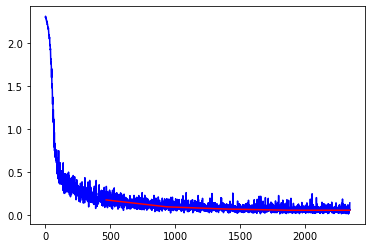

Método ejecutado SGD tiempo de ejecución en segundos: 43.568702936172485




Adam algorithm

Validation set: Average loss: 0.0259, Accuracy: 9917/10000 (99%)



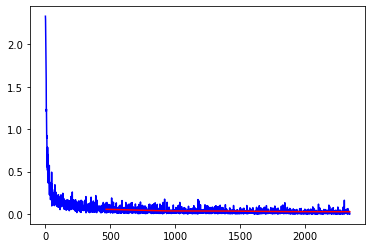

Método ejecutado Adam tiempo de ejecución en segundos: 45.481597661972046




RMSprop algorithm

Validation set: Average loss: 2.3037, Accuracy: 1028/10000 (10%)



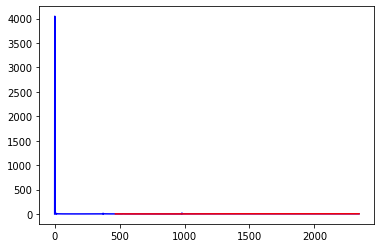

Método ejecutado RMSprop tiempo de ejecución en segundos: 44.51846766471863






In [15]:
algorithms = ('SGD','Adam','RMSprop')
Loss = []
Losses = []
for i in range(1,4):
  #1 for SGD, 2 for Adam, 3 for rmsprop
  start = time.time()
  Loss = neuronalWorking(i)
  Losses.append([Loss])
  end = time.time()
  print('Método ejecutado '+algorithms[i-1]+ ' tiempo de ejecución en segundos: ' + str((end-start)))
  print('\n')
  print('\n')

As we can see RMSprop didn't work with lr = 0.01 (default value). Let's see with lr = 0.001.

In [0]:
def optimization(algorithm, model):
  #algorithm 1 is SGD algorithm; algorithm 2 is Adam algorithm; algorithm 3 is rmsprop algorithm;
  #Paremeters shared by the algorithms:
  LR = 0.01; #0.01 default value
  MOMENTUM = 0.5; #0 for rmsprop, Adam not momentum need it. 0.5 default for SGD
  EPS = 1e-08;  #1e-08 default value. SGD no need parameter
  if algorithm == 1:
      #SGD
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
      print("SGD algorithm")
  elif algorithm == 2:
      #Adam
      optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
      print("Adam algorithm")
  elif algorithm == 3:
      #rmsprop
      optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
      print("RMSprop algorithm")

  return optimizer;

SGD algorithm

Validation set: Average loss: 0.0465, Accuracy: 9854/10000 (99%)



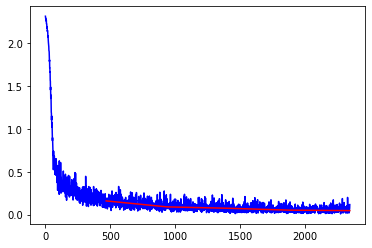

Método ejecutado SGD tiempo de ejecución en segundos: 43.97734785079956




Adam algorithm

Validation set: Average loss: 0.0281, Accuracy: 9908/10000 (99%)



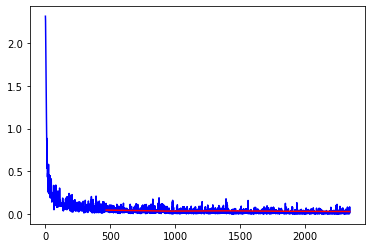

Método ejecutado Adam tiempo de ejecución en segundos: 44.511252641677856




RMSprop algorithm

Validation set: Average loss: 0.0407, Accuracy: 9886/10000 (99%)



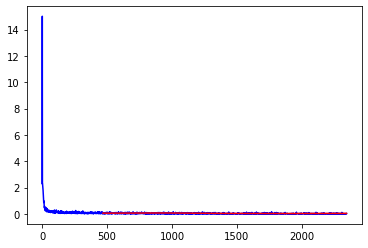

Método ejecutado RMSprop tiempo de ejecución en segundos: 43.11914420127869






In [17]:
algorithms = ('SGD','Adam','RMSprop')
Loss = []
Losses = []
for i in range(1,4):
  #1 for SGD, 2 for Adam, 3 for rmsprop
  start = time.time()
  Loss = neuronalWorking(i)
  Losses.append([Loss])
  end = time.time()
  print('Método ejecutado '+algorithms[i-1]+ ' tiempo de ejecución en segundos: ' + str((end-start)))
  print('\n')
  print('\n')

Now we see RMSprop has the best performance due to time spent and loss. Adam has better accuracy than RMSprop but is more noisy and spends more time than others.

Let's see what happen if we increase momentum on SGD and RMSprop to 0.9

In [0]:
def optimization(algorithm, model):
  #algorithm 1 is SGD algorithm; algorithm 2 is Adam algorithm; algorithm 3 is rmsprop algorithm;
  #Paremeters shared by the algorithms:
  LR = 0.01; #0.01 default value
  MOMENTUM = 0.5; #0 for rmsprop, Adam not momentum need it. 0.5 default for SGD
  EPS = 1e-08;  #1e-08 default value. SGD no need parameter
  if algorithm == 1:
      #SGD
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
      print("SGD algorithm")
  elif algorithm == 2:
      #Adam
      optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
      print("Adam algorithm")
  elif algorithm == 3:
      #rmsprop
      optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)
      print("RMSprop algorithm")

  return optimizer;

SGD algorithm

Validation set: Average loss: 0.0293, Accuracy: 9904/10000 (99%)



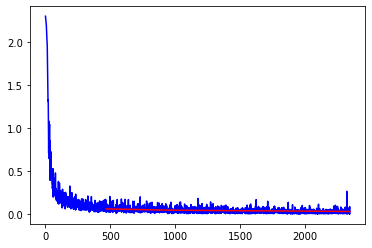

Método ejecutado SGD tiempo de ejecución en segundos: 43.25088882446289




Adam algorithm

Validation set: Average loss: 0.0387, Accuracy: 9882/10000 (99%)



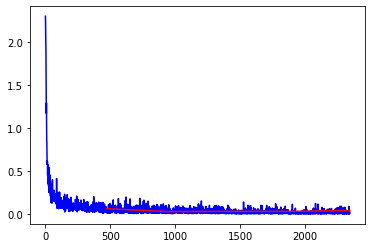

Método ejecutado Adam tiempo de ejecución en segundos: 43.470457792282104




RMSprop algorithm

Validation set: Average loss: 2.3018, Accuracy: 1028/10000 (10%)



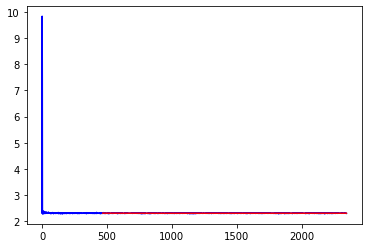

Método ejecutado RMSprop tiempo de ejecución en segundos: 43.380455493927






In [19]:
algorithms = ('SGD','Adam','RMSprop')
Loss = []
Losses = []
for i in range(1,4):
  #1 for SGD, 2 for Adam, 3 for rmsprop
  start = time.time()
  Loss = neuronalWorking(i)
  Losses.append([Loss])
  end = time.time()
  print('Método ejecutado '+algorithms[i-1]+ ' tiempo de ejecución en segundos: ' + str((end-start)))
  print('\n')
  print('\n')

SDG has the best performance, takes less time and has better accuracy than Adam. RMSprop failed with 0.9 momentum. Now we wil try RMSprop with 0.5 momentum.

In [0]:
def optimization(algorithm, model):
  #algorithm 1 is SGD algorithm; algorithm 2 is Adam algorithm; algorithm 3 is rmsprop algorithm;
  #Paremeters shared by the algorithms:
  LR = 0.01; #0.01 default value
  MOMENTUM = 0.5; #0 for rmsprop, Adam not momentum need it. 0.5 default for SGD
  EPS = 1e-08;  #1e-08 default value. SGD no need parameter
  if algorithm == 1:
      #SGD
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
      print("SGD algorithm")
  elif algorithm == 2:
      #Adam
      optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
      print("Adam algorithm")
  elif algorithm == 3:
      #rmsprop
      optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.5, centered=False)
      print("RMSprop algorithm")

  return optimizer;

SGD algorithm

Validation set: Average loss: 0.0305, Accuracy: 9901/10000 (99%)



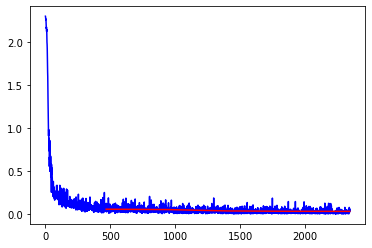

Método ejecutado SGD tiempo de ejecución en segundos: 43.083590507507324




Adam algorithm

Validation set: Average loss: 0.0250, Accuracy: 9917/10000 (99%)



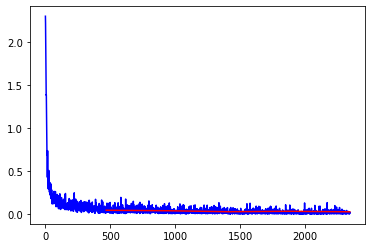

Método ejecutado Adam tiempo de ejecución en segundos: 43.58955788612366




RMSprop algorithm

Validation set: Average loss: 0.0433, Accuracy: 9880/10000 (99%)



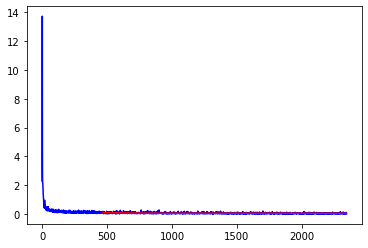

Método ejecutado RMSprop tiempo de ejecución en segundos: 43.349528551101685






In [21]:
algorithms = ('SGD','Adam','RMSprop')
Loss = []
Losses = []
for i in range(1,4):
  #1 for SGD, 2 for Adam, 3 for rmsprop
  start = time.time()
  Loss = neuronalWorking(i)
  Losses.append([Loss])
  end = time.time()
  print('Método ejecutado '+algorithms[i-1]+ ' tiempo de ejecución en segundos: ' + str((end-start)))
  print('\n')
  print('\n')

SDG is still the best with momentum 0.9 and time spent, but RMSprop has less noise.

Finally we will try with more learning rates for the 3 optimizers.

In [0]:
def optimization(algorithm, model):
  #algorithm 1 is SGD algorithm; algorithm 2 is Adam algorithm; algorithm 3 is rmsprop algorithm;
  #Paremeters shared by the algorithms:
  LR = 0.01; #0.01 default value
  MOMENTUM = 0.5; #0 for rmsprop, Adam not momentum need it. 0.5 default for SGD
  EPS = 1e-08;  #1e-08 default value. SGD no need parameter
  if algorithm == 1:
      #SGD
      optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
      print("SGD algorithm")
  elif algorithm == 2:
      #Adam
      optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
      print("Adam algorithm")
  elif algorithm == 3:
      #rmsprop
      optimizer = optim.RMSprop(model.parameters(), lr=0.007, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.5, centered=False)
      print("RMSprop algorithm")

  return optimizer;

SGD algorithm

Validation set: Average loss: 0.0302, Accuracy: 9905/10000 (99%)



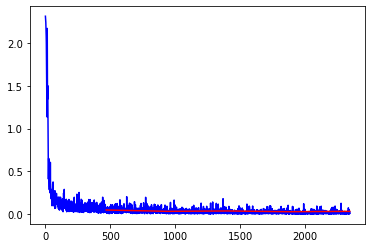

Método ejecutado SGD tiempo de ejecución en segundos: 43.36020350456238




Adam algorithm

Validation set: Average loss: 0.0550, Accuracy: 9831/10000 (98%)



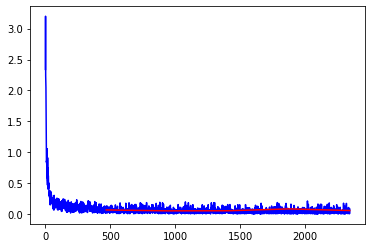

Método ejecutado Adam tiempo de ejecución en segundos: 43.14004731178284




RMSprop algorithm

Validation set: Average loss: 2.3015, Accuracy: 1135/10000 (11%)



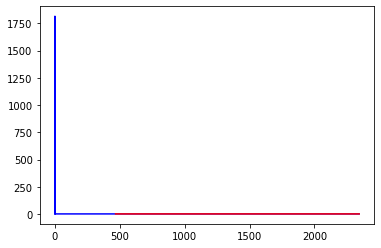

Método ejecutado RMSprop tiempo de ejecución en segundos: 43.18367052078247






In [23]:
algorithms = ('SGD','Adam','RMSprop')
Loss = []
Losses = []
for i in range(1,4):
  #1 for SGD, 2 for Adam, 3 for rmsprop
  start = time.time()
  Loss = neuronalWorking(i)
  Losses.append([Loss])
  end = time.time()
  print('Método ejecutado '+algorithms[i-1]+ ' tiempo de ejecución en segundos: ' + str((end-start)))
  print('\n')
  print('\n')